In [47]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import cmocean

In [4]:
df = pd.read_csv('data.csv')

### Linear Regression Benchmark

In [67]:
print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517    

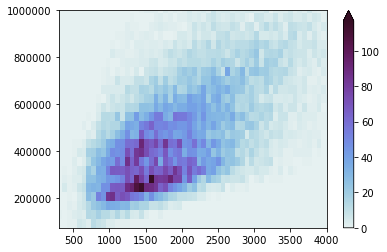

In [27]:
_,_,_,_=plt.hist2d(df.sqft_living, df.price,
              bins=200,cmap=cmocean.cm.dense)
plt.xlim(300,4000)
plt.ylim(7.5e4,1e6)
plt.colorbar(extend='m')

In [51]:
m, b, r_value, p_value, std_err = stats.linregress(df.sqft_living,df.price)

Text(2800, 250000.0, 'RMSE: $261,441')

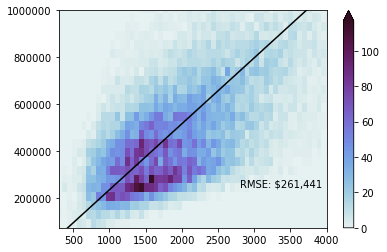

In [83]:
_,_,_,_=plt.hist2d(df.sqft_living, df.price,
              bins=200,cmap=cmocean.cm.dense)
plt.xlim(300,4000)
plt.ylim(7.5e4,1e6)
plt.colorbar(extend='max')

sqft = np.linspace(0,1e4,10)

y_lin = m*sqft + b

plt.plot(sqft,y_lin,color='k')

y_lin = m*df.sqft_living + b

rmse = (((df.price-y_lin)**2).sum()/len(y_lin))**0.5

plt.text(x=2800,y=2.5e5,s=f'RMSE: ${rmse:,g}')